## Data Cleansing and storing to a new CSV file; 'datasets/processed/cleaned_data_v1.csv'

In [1]:

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path_to_scripts = '../../scripts/utilities/'
sys.path.append(path_to_scripts)
from smiles_property_extractor import ChemicalInfoFromSmiles


In [2]:

db_name = '../../datasets/raw/somas_database.csv'
rename_some_columns = True


In [3]:

print(f'Reading DB: {db_name} ...')
db = pd.read_csv(db_name)


Reading DB: ../../datasets/raw/somas_database.csv ...


In [4]:

if rename_some_columns:
    print('Renaming some columns ...')
    db = db.rename(columns={
    'Molar Mass': 'MolarMass',
    'CAS Number': 'CASNumber',
    'Experimental Solubility in Water': 'ExperimentalSolubilityInWater',
    'Experiment Reference': 'ExperimentReference',
    'Solvation Energy': 'SolvationEnergy',
    'Dipole Moment': 'DipoleMoment',
    'Molecular Volume': 'MolecularVolume',
    'Molecular Surface Area': 'MolecularSurfaceArea',
    'Standard InChIKey': 'StandardInChIKey',
    'Cal logP': 'CalLogP',
    'Cal MR': 'CalMR',
    'Labute ASA': 'LabuteASA',
    'Balaban J index': 'BalabanJIndex',
    'Bertz CT index': 'BertzCTIndex'
    })


Renaming some columns ...


In [5]:

print('Adding aromaticity information to the database ...')
db = db.assign(Aromatic=lambda x: x['SMILES'].apply(ChemicalInfoFromSmiles.is_aromatic))


Adding aromaticity information to the database ...


In [6]:

print('Adding cyclicity information to the database ...')
db = db.assign(Cyclic=lambda x: x['SMILES'].apply(ChemicalInfoFromSmiles.is_cyclic))


Adding cyclicity information to the database ...


In [7]:

print('Adding charge neutrality information to the database ...')
db = db.assign(ChargeNeutral=lambda x: x['SMILES'].apply(ChemicalInfoFromSmiles.is_neutral))


Adding charge neutrality information to the database ...


In [8]:

#key_elements = {'Br', 'I', 'Cl', 'F', 'H', 'C', 'N', 'O', 'S', 'P'}
print('Adding information of "key_elements"-made ...')
db = db.assign(MadeOfKeyElements=lambda x: x['SMILES'].apply(
    ChemicalInfoFromSmiles.is_composed_of_specific_elements)
              )


Adding information of "key_elements"-made ...


In [9]:

#filteration 1
print('Filter records based on aromaticity == True and reset indices ...')
db_filtered = db[db['Aromatic'] == True]
db_updated = db_filtered.reset_index(drop=True)

number_of_excluded_molecues = db.shape[0] - db_updated.shape[0]
print(f'{number_of_excluded_molecues} were excluded!')


Filter records based on aromaticity == True and reset indices ...
6845 were excluded!


In [10]:

#filteration 2
print('Filter records based on cyclicity == True and reset indices ...')
db_filtered_ = db_updated[db_updated['Cyclic'] == True]
db_updated_ = db_filtered_.reset_index(drop=True)

number_of_excluded_molecues = db_updated.shape[0] - db_updated_.shape[0]
print(f'{number_of_excluded_molecues} were excluded!')


Filter records based on cyclicity == True and reset indices ...
0 were excluded!


In [11]:

#filteration 3
print('Filter records based on ChargeNeutral == True and reset indices ...')
db_filtered = db_updated_[db_updated_['ChargeNeutral'] == True]
db_updated = db_filtered.reset_index(drop=True)

number_of_excluded_molecues = db_updated_.shape[0] - db_updated.shape[0]
print(f'{number_of_excluded_molecues} were excluded!')


Filter records based on ChargeNeutral == True and reset indices ...
3 were excluded!


In [12]:

#filteration 4
print('Filter records based on MadeOfKeyElements == True and reset indices ...')
db_filtered_ = db_updated_[db_updated_['MadeOfKeyElements'] == True]
db_updated_ = db_filtered_.reset_index(drop=True)

number_of_excluded_molecues = db_updated.shape[0] - db_updated_.shape[0]
print(f'{number_of_excluded_molecues} were excluded!')


Filter records based on MadeOfKeyElements == True and reset indices ...
18 were excluded!


In [13]:

#continue "#filteration 4"
#I found them by cheching images produced from below cell
print('Drop the following records with deterium')
molecules_indices_with_deterium = [339, 2030]
for idx in molecules_indices_with_deterium:
    smiles = db_updated_['SMILES'].iloc[idx]
    print(idx, smiles)

db_updated_.drop(molecules_indices_with_deterium, inplace=True)
db_updated_ = db_updated_.reset_index(drop=True)


Drop the following records with deterium
339 [2H]C1=C(C(=C(C(=C1[2H])[2H])C(=O)O)[2H])[2H]
2030 [2H]C1=C(C(=C2C(=C1[2H])C(C(C(C2([2H])[2H])([2H])[2H])([2H])[2H])([2H])[2H])[2H])[2H]


In [14]:

print('In total 20 samples were excluded!')


In total 20 samples were excluded!


### Target values distribution ...

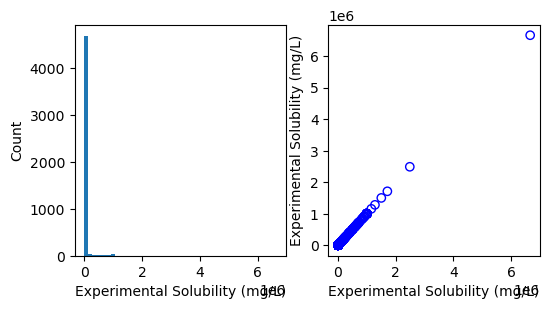

In [15]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
#hist
db_updated_['ExperimentalSolubilityInWater'].hist(bins=50, ax=ax1, grid=False)
ax1.set_xlabel('Experimental Solubility (mg/L)')
ax1.set_ylabel('Count')
#scatter
ax2.scatter(db_updated_['ExperimentalSolubilityInWater'],
            db_updated_['ExperimentalSolubilityInWater'],
            edgecolor='blue', facecolors='none')
ax2.set_xlabel('Experimental Solubility (mg/L)')
ax2.set_ylabel('Experimental Solubility (mg/L)')
plt.show()


In [16]:

#filteration 5
print('Removing records with extraordinary solubilities ...')
db_updated_2 = db_updated_[db_updated_['ExperimentalSolubilityInWater'] < 1E6]
db_updated_2 = db_updated_2.reset_index(drop=True)


Removing records with extraordinary solubilities ...


In [17]:

number_of_samples_db_updated = db_updated_.shape[0]
number_of_samples_db_updated_2 = db_updated_2.shape[0]
print('Number of excluded data due to filteration 2:')
number_of_samples_db_updated - number_of_samples_db_updated_2


Number of excluded data due to filteration 2:


41

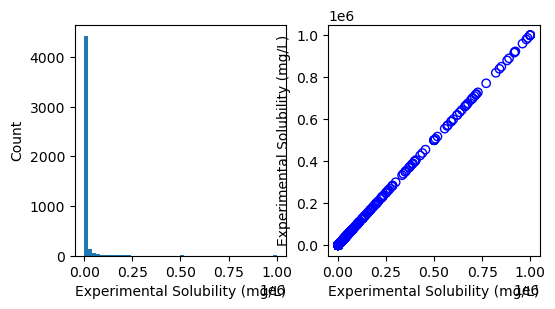

In [18]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
#hist
db_updated_2['ExperimentalSolubilityInWater'].hist(bins=50, ax=ax1, grid=False)
ax1.set_xlabel('Experimental Solubility (mg/L)')
ax1.set_ylabel('Count')
#scatter
ax2.scatter(db_updated_2['ExperimentalSolubilityInWater'],
            db_updated_2['ExperimentalSolubilityInWater'],
            edgecolor='blue', facecolors='none')
ax2.set_xlabel('Experimental Solubility (mg/L)')
ax2.set_ylabel('Experimental Solubility (mg/L)')
plt.show()


In [19]:

#filteration 6
print('Removing records with molar mass >= 500 Da ...')
db_updated_2_ = db_updated_2[db_updated_2['MolarMass'] < 500]
db_updated = db_updated_2_.reset_index(drop=True)


Removing records with molar mass >= 500 Da ...


In [20]:

number_of_samples_db_updated_2 = db_updated_2.shape[0]
number_of_samples_db_updated = db_updated.shape[0]
print('Number of excluded data due to filteration 2:')
number_of_samples_db_updated_2 - number_of_samples_db_updated


Number of excluded data due to filteration 2:


122

In [21]:

#filteration 7
print('Check duplications based on smiles')
duplicates = db_updated.duplicated(subset='SMILES', keep=False)
print(f'Number of duplications based on SMILES is: {db_updated[duplicates].shape[0]}')

print('Check duplications based on names')
duplicates = db_updated.duplicated(subset='Name', keep=False)
print(f'Number of duplications based on Name is: {db_updated[duplicates].shape[0]}')


Check duplications based on smiles
Number of duplications based on SMILES is: 0
Check duplications based on names
Number of duplications based on Name is: 0


In [22]:

is_making_images = False

if is_making_images:
    print('Generating molecular images: takes a few minutes ...')
    ChemicalInfoFromSmiles.get_pngs_from_simles(db_updated, dirname='images')


In [23]:

#continue "#filteration 8"
#I found that some molecules (30) are completely different and 
#shuold be excluded. Indeed, some of them cannot be proceed by Jazzy
# Does not proceed by Jazzy: 2397, 3652, 3926, 3944, 3946, 4041
print('Drop the case that can not be analyzed by Jazzy ...')
molecules_indices = [2397, 3652, 3926, 3944, 3946, 4041, 1689, 1791, 2397, 2459, 3019, 3147,
                     3220, 3329, 3447, 3457, 3505, 3578, 3652, 3926, 3944, 3946, 3956, 4028,
                     4036, 4041, 4055, 4117, 4148, 4136, 4169, 4199, 4234, 4394, 4412, 4468]
for idx in molecules_indices:
    smiles = db_updated['SMILES'].iloc[idx]
    print(idx, smiles)

db_updated.drop(molecules_indices, inplace=True)
db_updated_ = db_updated.reset_index(drop=True)


Drop the case that can not be analyzed by Jazzy ...
2397 CC(C)[C@@]1(O)[C@@H](OC(=O)C2=CC=CN2)[C@@]2(O)[C@@]3(C)C[C@]4(O)O[C@@]5([C@H](O)[C@@H](C)CC[C@]35O)[C@@]2(O)[C@@]14C
3652 [H][C@@](O)(C1=CC=NC2=CC=C(OC)C=C12)[C@]1([H])C[C@@H]2CC[N@]1C[C@@H]2C(O)=O
3926 [H][C@@](O)(C1=CC=NC2=CC=CC=C12)[C@]1([H])C[C@@H]2CC[N@]1C[C@@H]2C=C
3944 [H][C@](O)(C1=CC=NC2=CC=CC=C12)[C@@]1([H])C[C@@H]2CC[N@]1C[C@@H]2CC
3946 [H][C@](O)(C1=CC=NC2=C1C=CC=C2)[C@@]1([H])C[C@@H]2CC[N@]1C[C@@H]2C=C
4041 C1[C@H]2CNC[C@H]1C3=CC=CC(=O)N3C2
1689 CS(=O)(=O)C1=CC(=C(C=C1)C(=O)C2=C(C3CCC(C3)C2=O)SC4=CC=CC=C4)Cl
1791 CN1C=C(C(=N1)C(F)F)C(=O)NC2=CC=CC3=C2[C@@H]4CC[C@H]3C4=C(Cl)Cl
2397 CC(C)[C@@]1(O)[C@@H](OC(=O)C2=CC=CN2)[C@@]2(O)[C@@]3(C)C[C@]4(O)O[C@@]5([C@H](O)[C@@H](C)CC[C@]35O)[C@@]2(O)[C@@]14C
2459 C(NC12OC3C4C5C(C14)C1CC5C3C21)C1=CC=CC=C1
3019 CN1C2CCC1CN(C2)C(=O)C(CO)(C3=CC=CC=C3)C4=CC=CC=C4
3147 COC1=CC2=C(C=CN=C2C=C1)[C@@H]([C@H]3C[C@@H]4CCN3C[C@@H]4C=C)O
3220 CCCN1C2=C(C(=O)N(C1=O)CCC)NC(=N2)C34CC5CC(C3)CC4C5
3

In [24]:

db_updated_


,Name,SMILES,MolarMass,CASNumber,ExperimentalSolubilityInWater,Temperature,ExperimentReference,Datagroup,SolvationEnergy,DipoleMoment,...,CalMR,TPSA,LabuteASA,BalabanJIndex,BertzCTIndex,Isomer,Aromatic,Cyclic,ChargeNeutral,MadeOfKeyElements
0,1.3.5-trichloro-2.4.6-triazine,C1(=NC(=NC(=N1)Cl)Cl)Cl,184.4120,000108-77-0,49791.200000,298.15,Horrobin. S.; Journal of the Chemical Society...,G1,19.37192,0.011313,...,34.8570,38.67,66.000146,3.165670,175.065178,1,True,True,True,True
1,1.3.5-Trinitrobenzene,C1=C(C=C(C=C1[N+](=O)[O-])[N+](=O)[O-])[N+](=O...,213.1062,000099-35-4,277.712920,288.15,OChem,G4,49.41304,0.023810,...,46.4052,129.42,81.390330,3.387380,377.173349,1,True,True,True,True
2,2.4.6-TRINITROBENZOIC ACID,C1=C(C=C(C(=C1[N+](=O)[O-])C(=O)O)[N+](=O)[O-]...,257.1160,000129-66-8,20517.720200,297.15,OChem,G4,69.83096,2.089799,...,53.3645,166.72,96.711028,3.764179,545.048475,1,True,True,True,True
3,3.5-DINITROBENZOIC ACID,C1=C(C=C(C=C1[N+](=O)[O-])[N+](=O)[O-])C(=O)O,212.1200,000099-34-3,1350.000000,298.15,YALKOWSKY.SH & DANNENFELSER.RM (1992),G2,55.60536,4.897608,...,46.7101,123.58,82.058053,3.387380,375.786527,1,True,True,True,True
4,2.4.6-TRINITROCHLOROBENZENE,[O-][N+](=O)C1=CC(=C(Cl)C(=C1)[N+]([O-])=O)[N+...,247.5513,000088-88-0,530.475354,289.15,OChem,G4,48.45072,0.310057,...,51.4152,129.42,91.693597,3.572755,466.032395,1,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4630,Metacil,CC1=CC(=O)N=C(N1)S,142.1752,000056-04-2,533.241385,298.15,OChem,G4,77.86424,10.247904,...,36.8467,45.75,57.552230,3.332335,244.655659,1,True,True,True,True
4631,MENAZON,COP(=S)(OC)SCC1=NC(=NC(=N1)N)N,281.2869,000078-57-9,239.965887,293.15,OChem,G4,83.93104,6.476270,...,68.2498,109.17,102.256998,2.708345,389.655410,1,True,True,True,True
4632,(2S)-2-acetamido-3-(3.5-dibromo-4-hydroxypheny...,CC(=O)N[C@@H](CC1=CC(=C(C(=C1)Br)O)Br)C(=O)O,381.0202,010346-50-6,2500.046006,298.15,Frontiers in Oncology 2020; 10.doi.10.3389/fon...,G4,88.61712,6.968232,...,72.4513,86.63,120.452583,2.938305,466.926711,2,True,True,True,True
4633,PIROXICAM,CN1/C(=C(\NC2=CC=CC=N2)/O)/C(=O)C3=CC=CC=C3S1(...,331.3500,036322-90-4,23.000000,295.15,YALKOWSKY.SH & DANNENFELSER.RM (1992),G2,118.15616,15.789171,...,83.2358,99.60,132.498707,2.134568,907.329050,2,True,True,True,True


In [25]:

db_updated_.index.name = 'molindx'
db_updated_.to_csv('../../datasets/processed/cleaned_data_v1.csv', index=True)
